In [1]:
!pip install opencv-contrib-python==3.4.0.12 

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
# read images
img0 = cv2.imread(r"dino0002.png", 0)
rgb0 = cv2.imread(r"dino0002.png")
img1 = cv2.imread(r"dino0001.png", 0)
rgb1 = cv2.imread(r"dino0001.png")

In [5]:
def parse_params(param_file):
    params = pd.read_csv(param_file, delimiter=' ', dtype=str, index_col=0, header=None, skiprows=1)
    params.columns = ['k11', 'k12', 'k13', 'k21', 'k22', 'k23', 
                      'k31', 'k32', 'k33', 'r11', 'r12', 'r13', 
                      'r21', 'r22', 'r23', 'r31', 'r32', 'r33', 
                      't1', 't2', 't3']
    params.index.name = 'image name'
    return params

In [6]:
def get_matrices(params, num):
    K = params.iloc[num,0:9].values.reshape(3,3).astype(float)
    R = params.iloc[num,9:18].values.reshape(3,3).astype(float)
    t = params.iloc[num,18:].values.reshape(3,1).astype(float)
    return K, R, t

In [7]:
params = parse_params("dino_par.txt")
K0, R0, t0 = get_matrices(params, 0)
K1, R1, t1 = get_matrices(params, 1)
f0 = K0[0,0]
f1 = K1[0,0]
px0, py0 = K0[0,2], K0[1,2]
px1, py1 = K1[0,2], K1[1,2]

In [8]:
# get matches
def get_matches(imgL, imgR, descriptor='sift'):
    if descriptor=='surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif descriptor=='sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    else:
        raise ValueError
        
    kpL, descL = descriptor.detectAndCompute(imgL, None)
    kpR, descR = descriptor.detectAndCompute(imgR, None)
    imgL_keypoints = cv2.drawKeypoints(imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    imgR_keypoints = cv2.drawKeypoints(imgR, kpR, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descL, descR, k=2) 
    
    good_matches = []
    good_matches_without_list = []
    # ratio test
    for m,n in matches:
        if m.distance < 0.75*n.distance: # only accept matchs that are considerably better than the 2nd best match
            good_matches.append([m])
            good_matches_without_list.append(m) # this is to simplify finding a homography later

    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good_matches_without_list ])
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good_matches_without_list ])
    return src_pts, dst_pts

In [9]:
# get correspondence points
img0_pts, img1_pts = get_matches(img0, img1)

In [10]:
def normalize_coordinates(img_pts):
    n = len(img_pts)
    # compute centroid in image
    centroid_x, centroid_y = img_pts.mean(0)
    O = np.array([[1, 0, -centroid_x],
                  [0, 1, -centroid_y],
                  [0, 0, 1]])
    
    # recenter
    recentered_pts = img_pts - [centroid_x,centroid_y]
    
    # find scale term
    s = np.sqrt(2) / np.sqrt(1/n * np.sum(recentered_pts**2))
    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]])

    # transformation matrix
    T = S @ O
    
    # new coordinates
    norm_pts = np.empty(img_pts.shape)
    for idx, pt in enumerate(img_pts):
        norm_pt = T @ np.array([[pt[0]], [pt[1]], [1]])
        norm_pt = (norm_pt[:2]).squeeze()
        norm_pts[idx] = norm_pt
    return T, norm_pts #return T s.t. we can convert back later

In [11]:
T0, img0_pts_norm = normalize_coordinates(img0_pts)
T1, img1_pts_norm = normalize_coordinates(img1_pts)

In [12]:
def eight_point(src_pts, dst_pts, T0, T1):
    # 8-point algorithm
    num_match = src_pts.shape[0]
    A = np.empty((num_match, 9))
    for idx in range(num_match):
        x0, y0 = src_pts[idx]
        x1, y1 = dst_pts[idx]
        A[idx] = [x1*x0, x1*y0, x1, y1*x0, y1*y0, y1, x0, y0, 1]

    # use SVD to solve F -- take column of V corresponding to least singular value
    U,S,VT = np.linalg.svd(A)
    V = VT.T
    F = V[:,-1].reshape(3,3)

    # enforce rank 2 constraint (Tsai and Huang) -- make last eigval 0
    U,S,VT = np.linalg.svd(F)
    S[-1] = 0
    F = U@(np.diag(S))@VT

    # need to un-normalize F
    F = T1.T @ F @ T0
    return F/F[2,2]

In [13]:
F = eight_point(img0_pts_norm, img1_pts_norm, T0, T1)

In [14]:
# epiline drawing function from cv2
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [15]:
len(img1_pts)

105

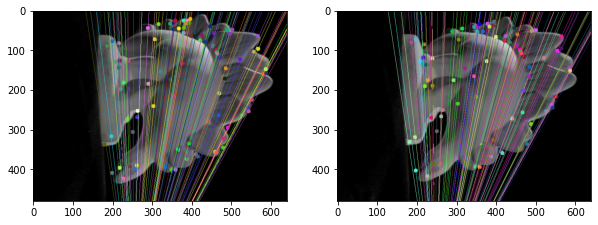

In [16]:
# epilines
# Right image
lines0 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F)
lines0 = lines0.reshape(-1,3)
img5,img6 = drawlines(img0,img1,lines0,img0_pts,img1_pts)
# Left image
lines1 = cv2.computeCorrespondEpilines(img0_pts.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img3,img4 = drawlines(img1,img0,lines1,img1_pts,img0_pts)

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img5)
plt.subplot(122)
plt.imshow(img3)
plt.show()

In [17]:
# get epipolar lines
def get_epipolar_lines(pts, F, image_num=0):
    """
    Calculates the epipolar lines
    Param:
        image_num: which image we are calculating for. If 0 --> left epiline, if 1 --> right epiline
    Returns:
        epipolar_lines: array of epipolar line coefficients [a,b,c] where 0=ax+by+cz
    """
    
    epipolar_lines = []
    for pt in pts:
        pt_x, pt_y = pt
        pt_arr = np.array([[pt_x],[pt_y],[1]])
        epipolar_line = F@pt_arr if image_num==0 else F.T@pt_arr
        a,b,c = epipolar_line
#         # normalize such that a^2 + b^2 = 1
#         k = 1/np.sqrt(a**2+b**2)
#         a, b = k*a, k*b
        epipolar_lines.append([a,b,c])
    return np.array(epipolar_lines).squeeze()

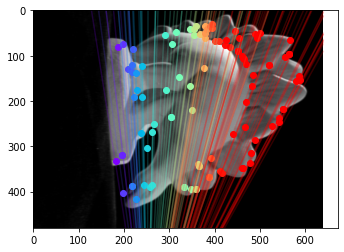

In [18]:
epipolar_lines = get_epipolar_lines(img0_pts, F, image_num=1)
height0, width0 = img0.shape
plt.imshow(img0, 'gray')
color = plt.cm.rainbow(np.linspace(0,10,width0))
for idx, epipolar_line in enumerate(epipolar_lines):
    a,b,c = epipolar_line
    x = np.linspace(0,width0,100)
    y = (a/-b)*x + (c/-b)
    plt.plot(x, y, '-r', alpha=0.2, c=color[idx])
    plt.scatter(img1_pts[idx][0], img1_pts[idx][1], color=color[idx])
plt.ylim(height0,0)
plt.show()

***
Ignore below

In [ ]:
# get epipoles
# U,S,VT = np.linalg.svd(F)
# idx = np.argmin(S)
# e0 = VT[idx]
# e0 = (e0/e0[2]).reshape(3,1)
# e1 = U[:,idx]
# e1 = (e1/e1[2]).reshape(3,1)

In [ ]:
# F @ e0

array([[ 1.18571819e-13],
       [-3.78586051e-14],
       [ 0.00000000e+00]])

In [ ]:
# F.T @ e1

array([[ 8.61533067e-14],
       [-2.77555756e-14],
       [ 1.13686838e-13]])

In [ ]:
# skew_mat0 = np.array([[0, -e0[2][0], e0[1][0]],
#                       [e0[2][0], 0, -e0[0][0]],
#                       [-e0[1][0], e0[0][0], 0]])
# skew_mat1 = np.array([[0, -e1[2][0], e1[1][0]],
#                       [e1[2][0], 0, -e1[0][0]],
#                       [-e1[1][0], e1[0][0], 0]])

In [ ]:
# Fbar = np.array([[0,0,0], [0,0, -1], [0, 1, 0]])
# H1 @ Fbar @ H0

array([[ 6.92395979e+13, -2.23065710e+13,  9.13673724e+13],
       [ 2.15794831e+14, -6.95215291e+13,  2.84759116e+14],
       [ 2.74858123e+11, -8.85496512e+10,  3.62698013e+11]])

In [ ]:
# Hartley's solution
# H1 = H0 @ ((skew_mat0 @ F) + (e0@e1.T))

In [ ]:
# H0.T @ Fbar @ H1

array([[ 5.33043579e-02, -5.70426487e+00,  4.46506760e+03],
       [ 5.71612691e+00, -1.36720914e-02, -1.42921722e+03],
       [-4.50123649e+03,  1.44769733e+03, -2.69883776e+03]])

***

In [19]:
img0_pts, img1_pts = get_matches(img0, img1)

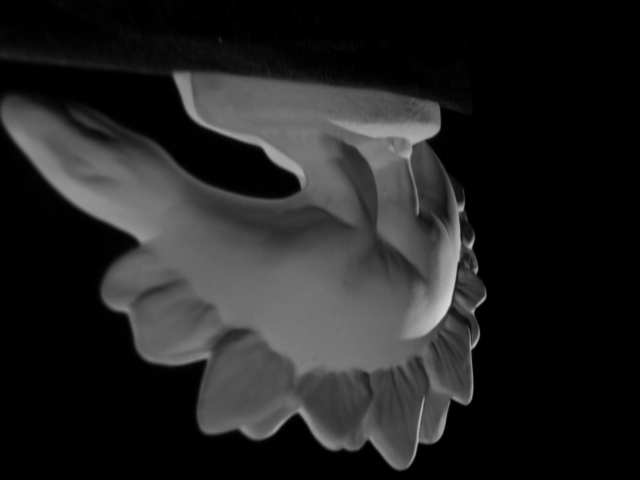

hmmmmm


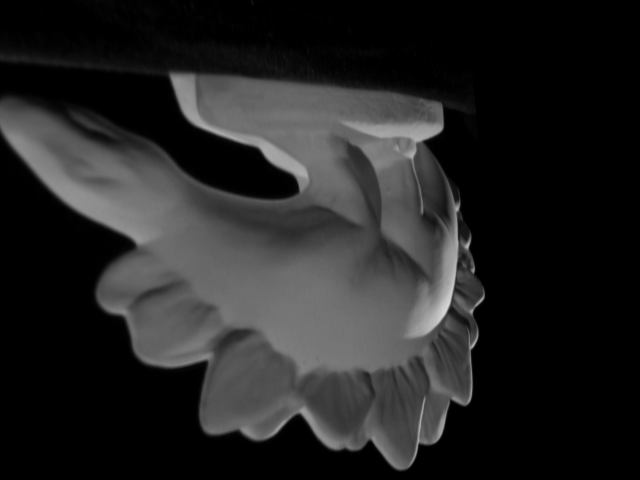

In [20]:
img0 = cv2.imread(r"dino0002.png", 0)
img1 = cv2.imread(r"dino0001.png", 0)
height0, width0 = img0.shape
height1, width1 = img1.shape
rect_lines = (F@ lines0[0].reshape(3,1)).reshape(1,3)

# img0_pts = np.array([[y,x] for (x,y) in img0_pts])
# img1_pts = np.array([[y,x] for (x,y) in img1_pts])

retval, H0, H1 = cv2.stereoRectifyUncalibrated(img0_pts, img1_pts, F, (width0, height0))
img0_rectified = cv2.warpPerspective(img0, H0, (width0, height0))
img1_rectified = cv2.warpPerspective(img1, H1, (width1, height1))

# rect_lines = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F)
# rect_lines = rect_lines.reshape(-1,3)
# img5,img6 = drawlines(img0_rectified,img1_rectified,lines0,img0_pts,img1_pts)
cv2_imshow(img0_rectified)
print("hmmmmm")
cv2_imshow(img1_rectified)

In [36]:
np.savetxt("img1_rectified_8point_SIFT.txt", img1_rectified)

In [32]:
# Find new intrinsics matrix
new_coords = H1 @ np.array([[px1], [py1], [1]])
new_coords / new_coords[-1]

array([[356.06939655],
       [232.02660924],
       [  1.        ]])

In [27]:
new_coords = H0 @ np.array([[px0], [py0], [1]])
new_coords / new_coords[-1]

array([[358.64238341],
       [231.53388618],
       [  1.        ]])

In [28]:
px0, py0

(316.73, 200.55)

In [ ]:
Fbar = np.array([[0,0,0], [0,0, -1], [0, 1, 0]])
testF = H1.T @ Fbar @ H0
testF/testF[2,2]

array([[-2.79229851e-05,  2.11573551e-03, -1.65413920e+00],
       [-2.14206598e-03,  1.62260364e-05,  5.26880973e-01],
       [ 1.66677863e+00, -5.36059868e-01,  1.00000000e+00]])

In [ ]:
F

array([[-2.79229851e-05,  2.11573551e-03, -1.65413920e+00],
       [-2.14206598e-03,  1.62260364e-05,  5.26880973e-01],
       [ 1.66677863e+00, -5.36059868e-01,  1.00000000e+00]])

In [ ]:
Fbar = np.array([[0,0,0], [0,0, -1], [0, 1, 0]])
test_F = H1 @ Fbar @ H0
test_F/test_F[2,2]

array([[-2.21623386e+01,  6.52112034e+00,  4.63102012e+02],
       [ 8.00079254e-01, -2.35396983e-01, -1.67348652e+01],
       [-4.78528613e-02,  1.40802944e-02,  1.00000000e+00]])

In [ ]:
F

array([[-2.79463181e-05,  2.11719127e-03, -1.65519554e+00],
       [-2.14354417e-03,  1.62374210e-05,  5.27232678e-01],
       [ 1.66784749e+00, -5.36416684e-01,  1.00000000e+00]])

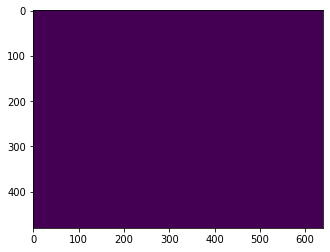

In [ ]:
out = cv2.warpPerspective(img0_pts, H1, (width, height))
plt.imshow(out)